In [1]:
import sys
import pathlib
sys.path.append('../il_pedagogical')

import il_pedagogical as ilp
import il_parse as ila
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pandas as pd
pd.options.display.float_format = '{:.0f}'.format

ini_pool_size = [25, 50, 75, 100]
plt.rcParams.update({'font.size': 18})
sns.set(style="white", palette="deep", color_codes=True, font_scale=1.5)
sns.set(style="white", palette="deep", color_codes=True, font_scale=1.5)

from scipy.stats import gaussian_kde

Exact <k>/A: 1.091E-08


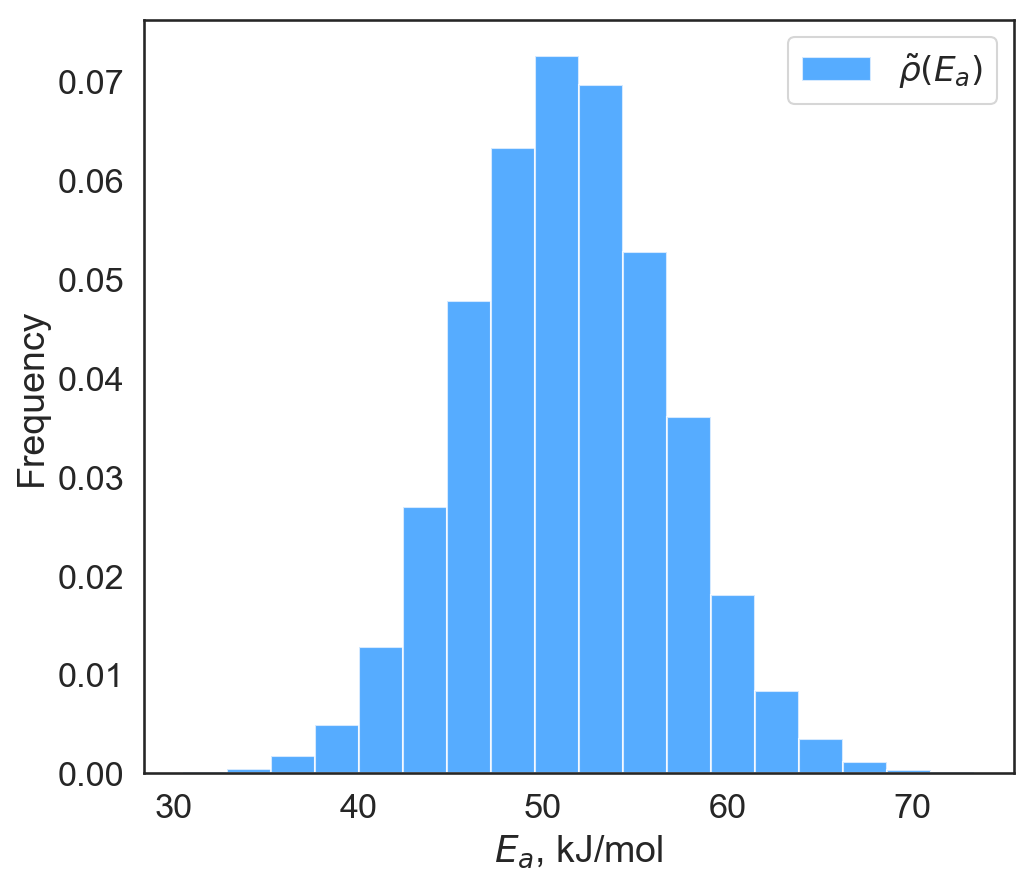

In [2]:
def k_perturb(B_windows, barrier_distribution, window_samples):
    n_windows = len(B_windows)
    k_windows = np.zeros((n_windows - 1, 1))

    for i in range(n_windows - 1):
        sampled_Ea = np.random.choice(barrier_distribution, window_samples, p=np.exp(-B_windows[i]*barrier_distribution)/np.sum(np.exp(-B_windows[i]*barrier_distribution)))
        k_windows[i] = np.sum(np.exp(-(B_windows[i+1] - B_windows[i]) * sampled_Ea)) / len(sampled_Ea)
    
    return np.prod(k_windows)

def k_random_sampling(barrier_distribution, B, samples):
    Ea = np.random.choice(barrier_distribution, samples)
    return np.sum(np.exp(-B * Ea)) / samples

il_morse = ila.Parser('../logs/IL_50.json')
T = 300
B = 1000/(8.314*T)
n_bins = 18

barrier_distribution = il_morse.true_barrier_heights()

avg_k = np.sum(np.exp(-B * barrier_distribution))/len(barrier_distribution)
print("Exact <k>/A: {:.3E}".format(avg_k))

fig, ax1 = plt.subplots(1, 1, figsize=(7, 6), dpi=150)
y, x, _ = ax1.hist(barrier_distribution, density=True,bins=n_bins, color='dodgerblue', alpha=0.75, label=r'$\tilde{\rho}(E_a)$')

plt.legend()

ax1.set_xlabel(r'$E_a$, kJ/mol')
ax1.set_ylabel('Frequency')
fig.tight_layout()
plt.show()


## Sampling in stages

# $$\frac{\langle k \rangle}{A} = \prod_{i=1}^{n} \langle \exp[-(\beta_{i} - \beta_{i-1}) E_a]\rangle_{\tilde\rho(E_a)e^{-\beta_{i-1}E_a}}$$

[0.         0.13364339 0.26728677 0.40093016]


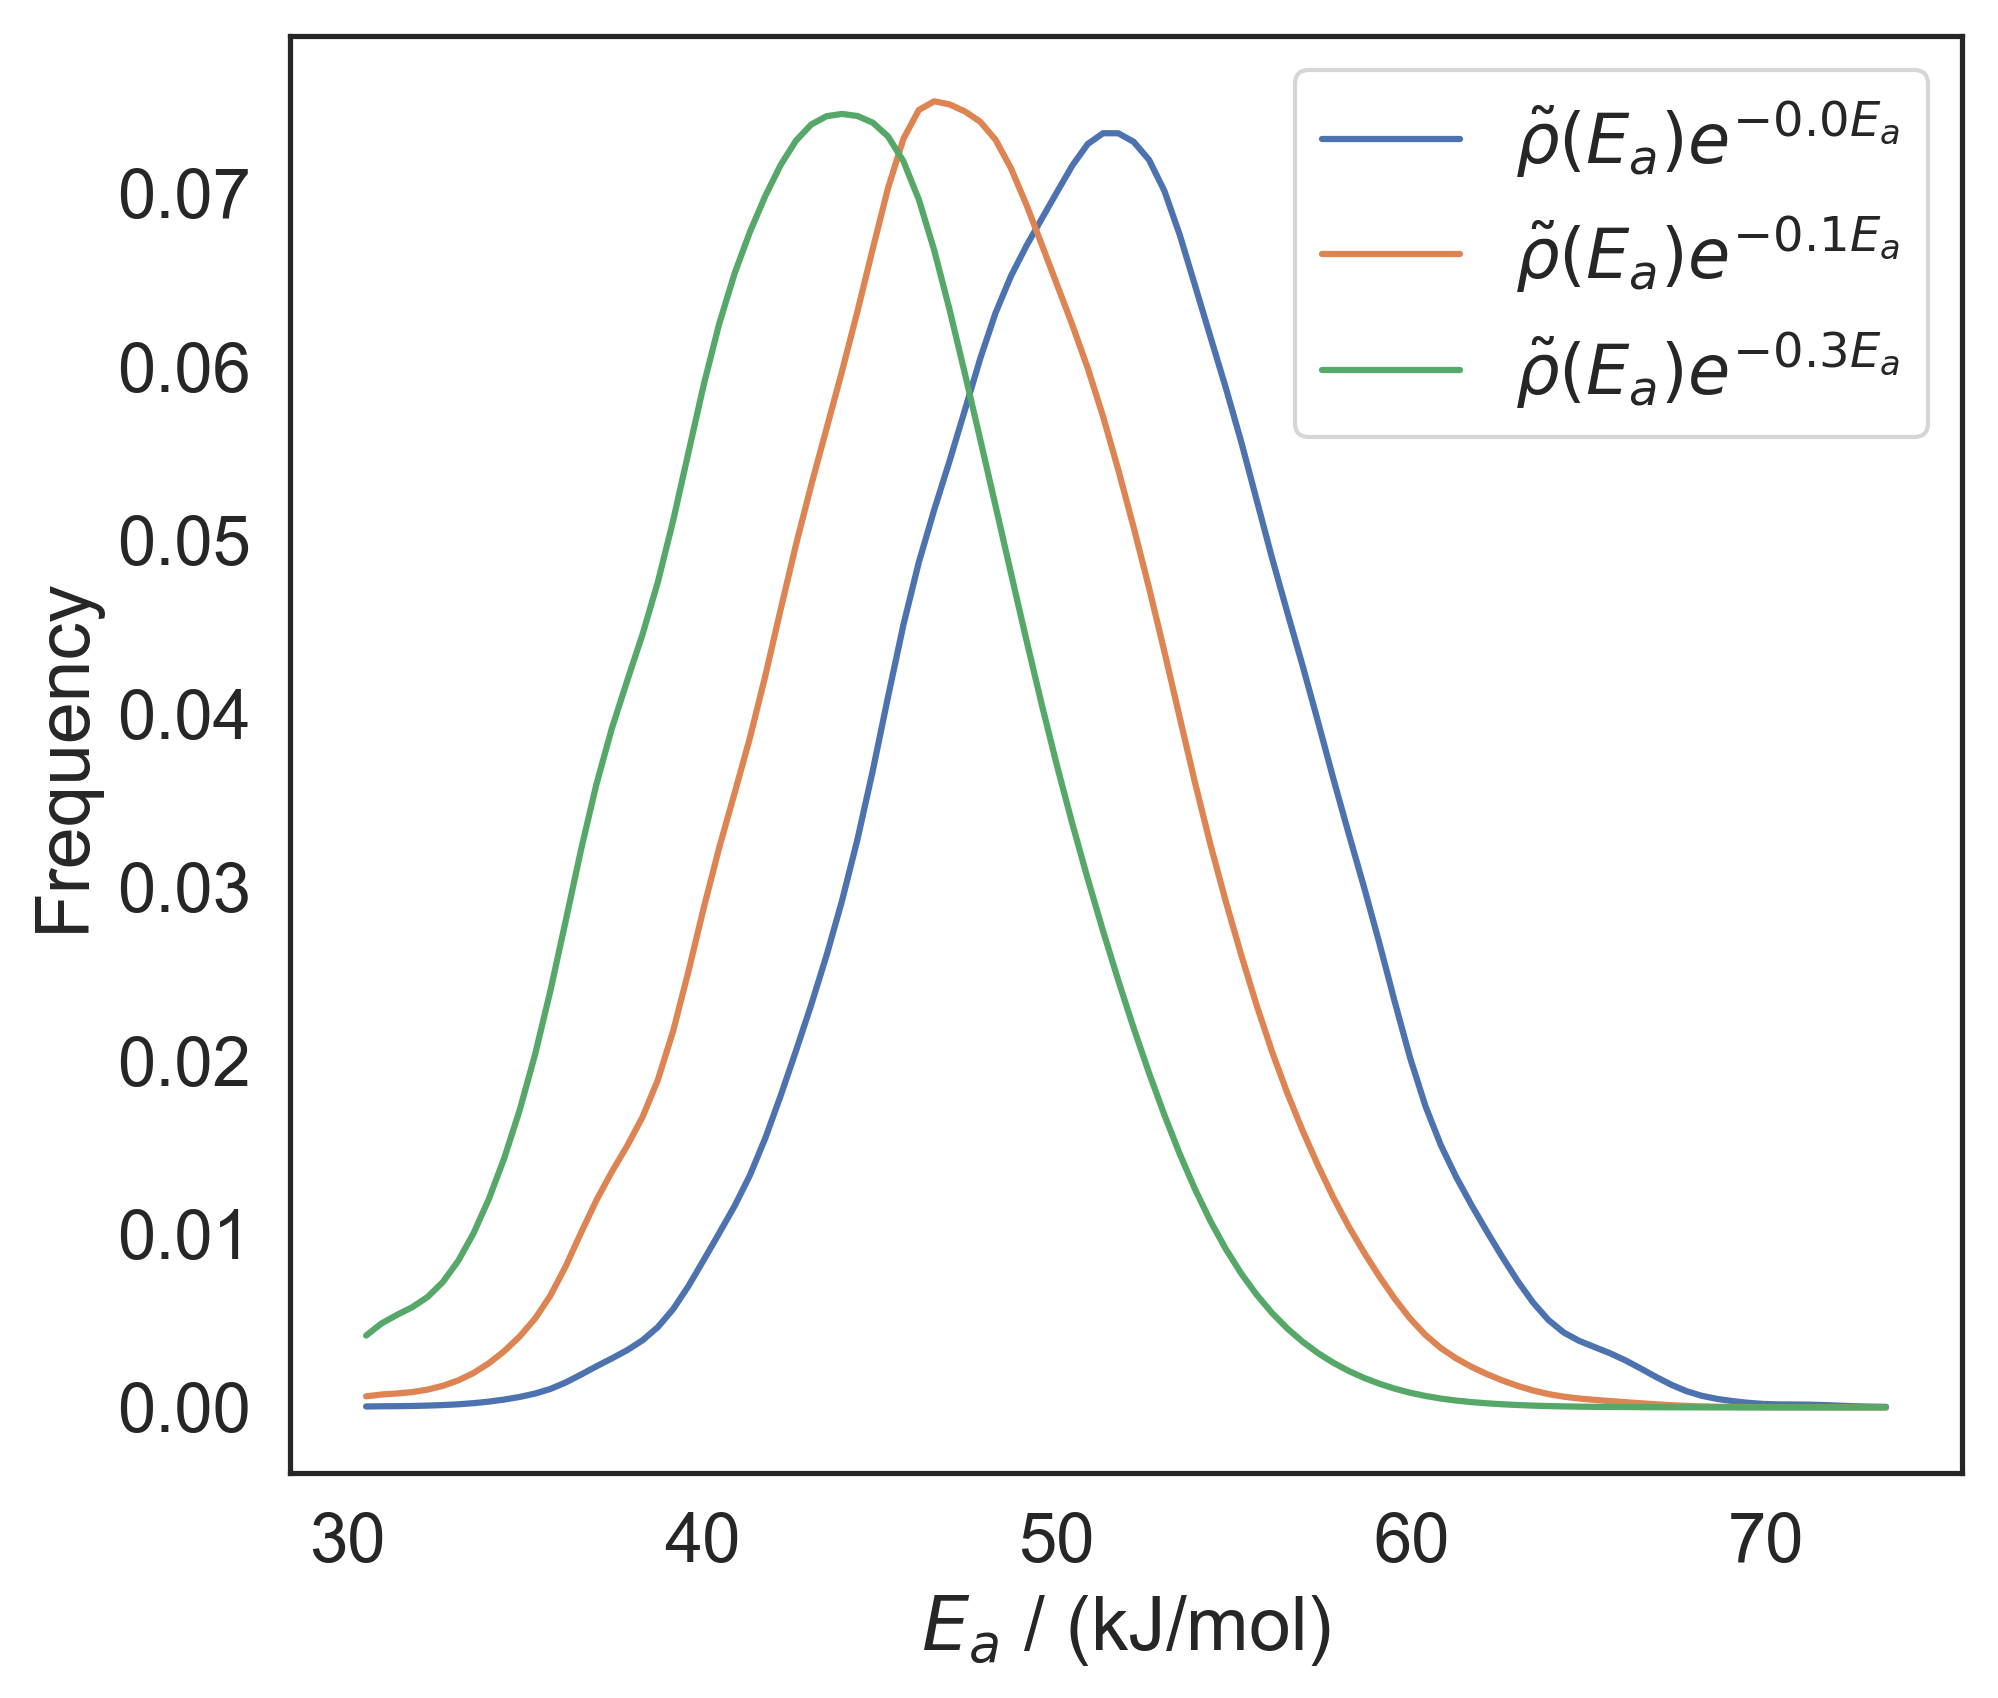

In [236]:
n_windows = 3

B_windows = np.linspace(0, B, n_windows+1)
print(B_window)
fig, ax1 = plt.subplots(1, 1, figsize=(7, 6), dpi=300)

Ea = np.linspace(min(barrier_distribution), max(barrier_distribution), 100)


for i in range(n_windows):
#     Use KDE to plot the distribution
    y = gaussian_kde(barrier_distribution, weights=np.exp(-B_windows[i] * barrier_distribution)).pdf(Ea)
    ax1.plot(Ea, y, label=r'$\tilde{\rho}(E_a)e^{-%.1f E_a}$' % (B_windows[i]))

plt.xlabel(r'$E_a$ / (kJ/mol)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

In [210]:
avg_k_perturb = [k_perturb(B_windows, barrier_distribution, 10) for i in range(50000)]

effective_samples = 10 * (n_windows - 1)
avg_k_random = [k_random_sampling(barrier_distribution, B, effective_samples) for i in range(50000)]

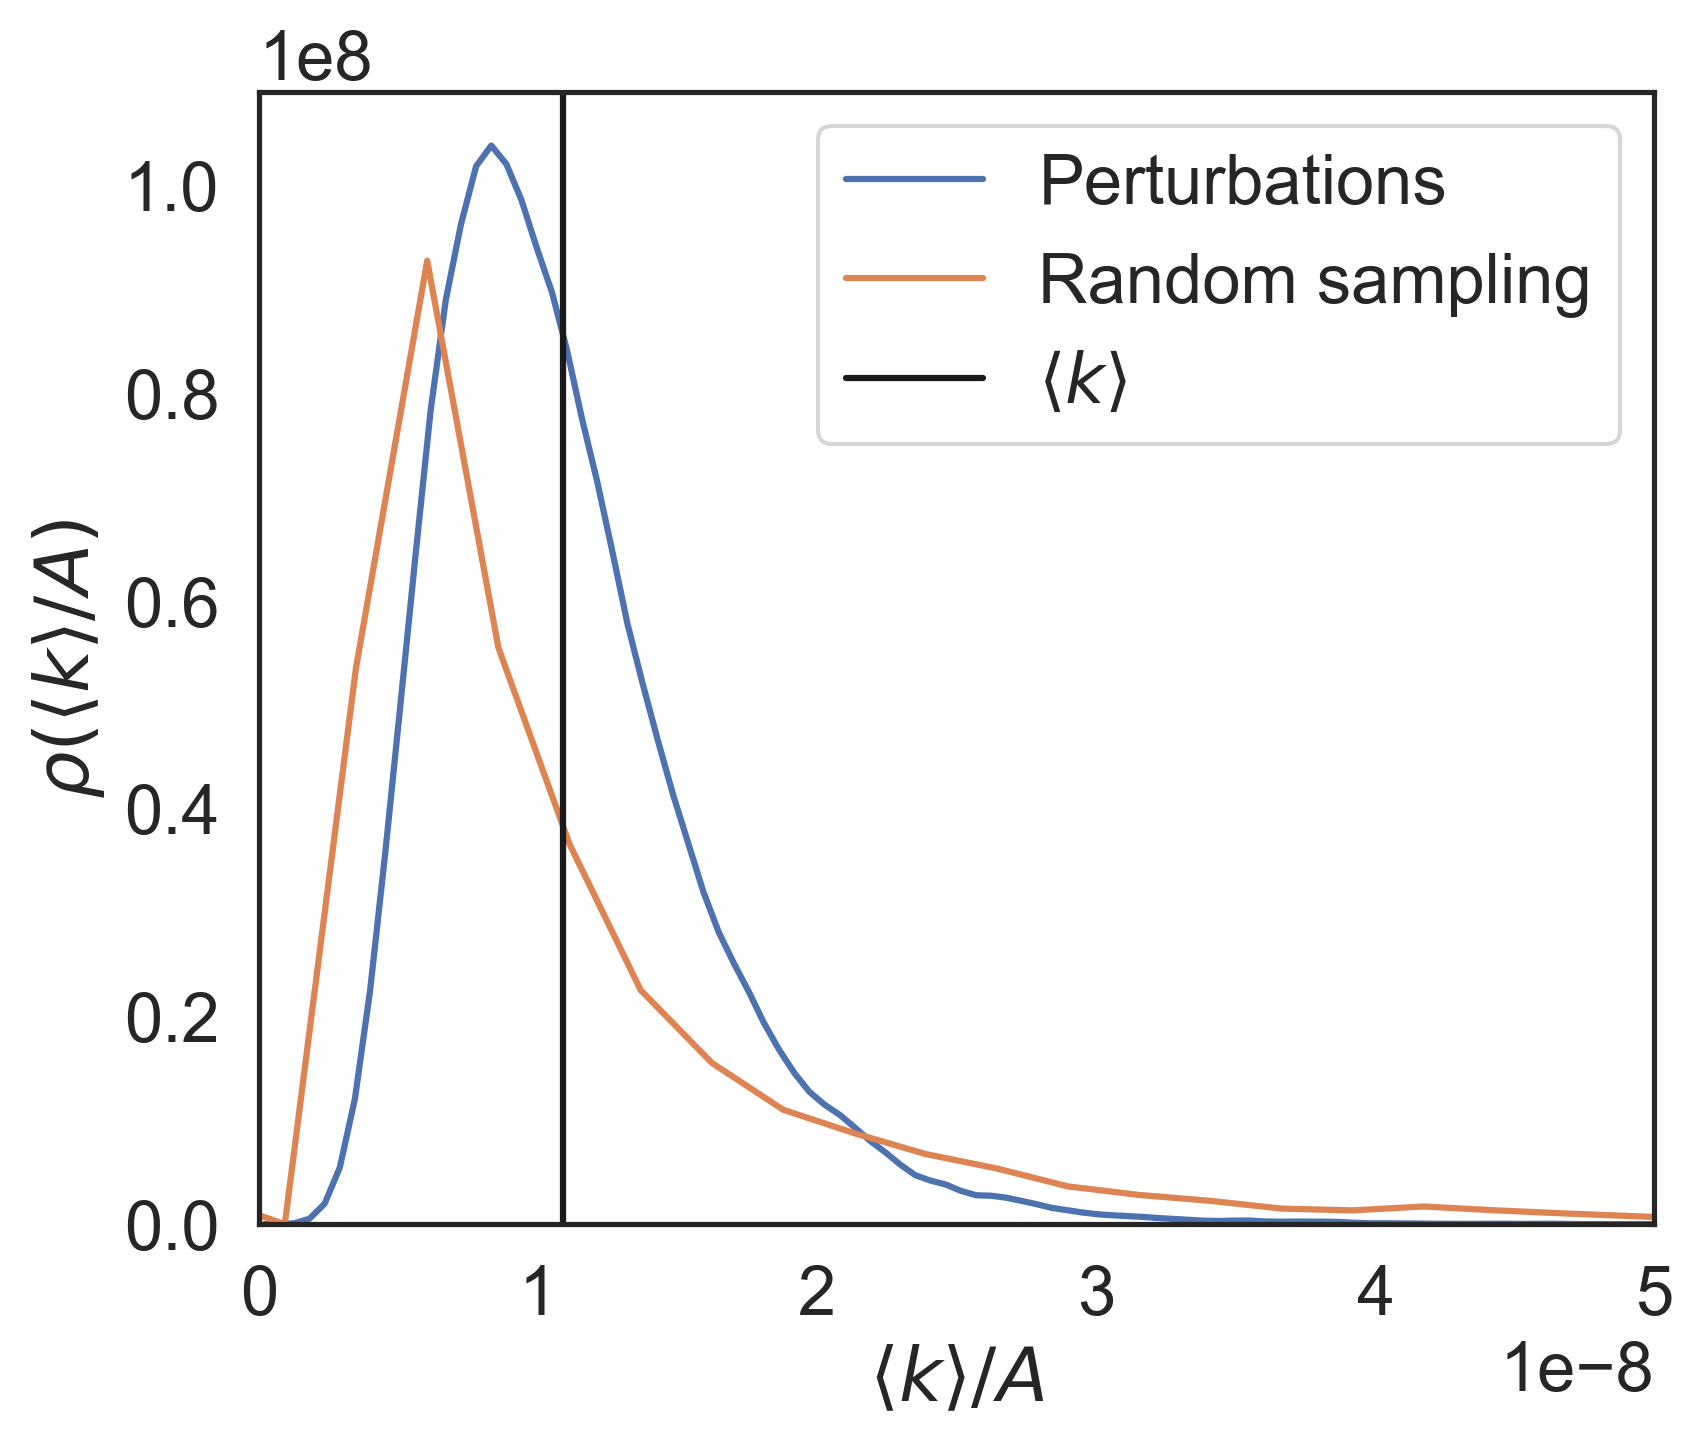

<k> / A, perturb.: 1.09E-08 +/- 4.79E-09
<k> / A, perturb.: 1.09E-08 +/- 1.55E-08
Relative uncertainty, perturb/random: 3.24
<k> / A, iter 30 IL: 1.03E-08
<k> / A exact: 1.09E-08


In [254]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5), dpi=300)
sns.distplot(avg_k_perturb, hist=False, norm_hist=True, ax=ax1, label='Perturbations')
sns.distplot(avg_k_random, hist=False, norm_hist=True, ax=ax1, label='Random sampling')
ax1.set_xlim([0, 5e-8])

y_lim = ax1.get_ylim()

ax1.plot([avg_k, avg_k], y_lim, color='k', label=r'$\langle k \rangle$')
ax1.set_ylim(y_lim)

plt.xlabel(r'$\langle k \rangle / A$')
plt.ylabel(r'$\rho(\langle k \rangle / A)$')
plt.legend()
plt.show()

Ea_IL_30 = il_morse.model_barrier_heights(30)

print('<k> / A, perturb.: {:.2E} +/- {:.2E}'.format(np.mean(avg_k_perturb), np.std(avg_k_perturb)))
print('<k> / A, perturb.: {:.2E} +/- {:.2E}'.format(np.mean(avg_k_random), np.std(avg_k_random)))
print('Relative uncertainty, perturb/random: {:.2f}'.format(np.std(avg_k_random)/np.std(avg_k_perturb)))
print('<k> / A, iter 30 IL: {:.2E}'.format(np.sum(np.exp(-B * Ea_IL_30))/len(Ea_IL_30)))
print('<k> / A exact: {:.2E}'.format(avg_k))


## Active site counting curves

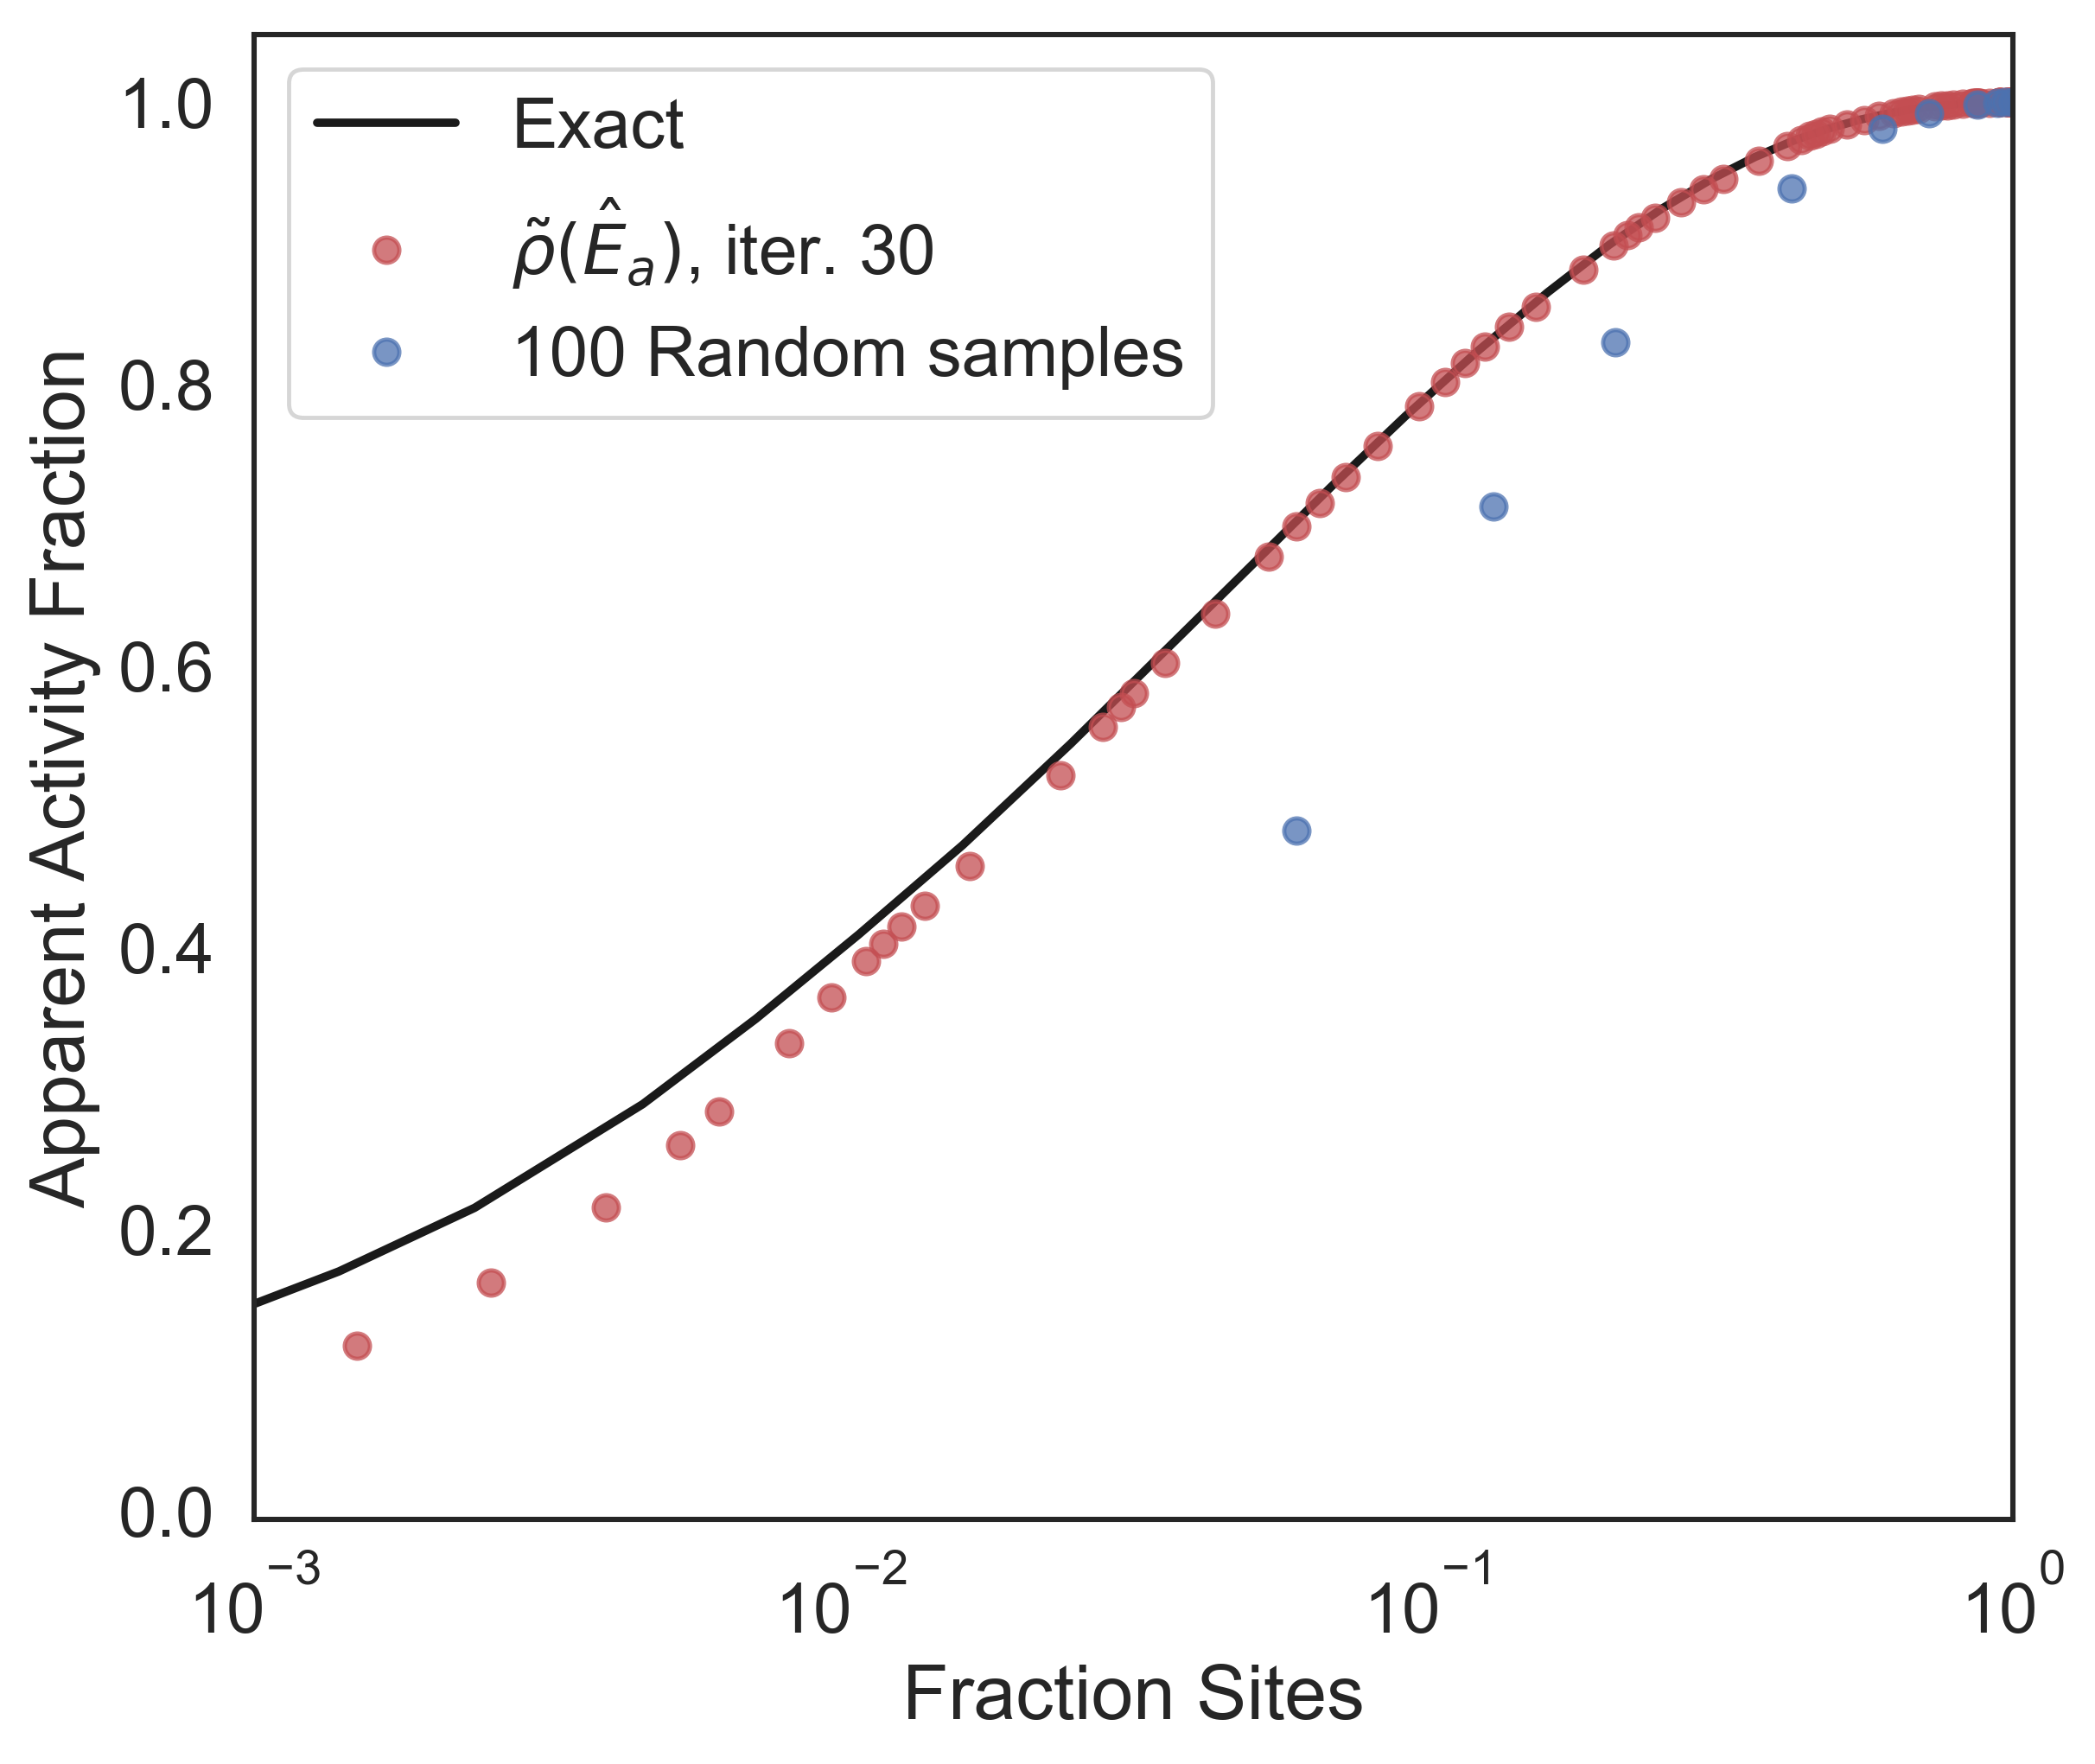

In [253]:
X_r, Y_r = ilp.active_site_counting(np.random.choice(barrier_distribution, 100), T, n_bins=10)

fig, ax1 = plt.subplots(1, 1, figsize=(7.5, 6.5), dpi=350)

true_barriers = il_morse.true_barrier_heights()
model_heights = il_morse.model_barrier_heights(30)

X, Y = ilp.active_site_counting(true_barriers, T)
X_m, Y_m = ilp.active_site_counting(model_heights, T, n_bins=100)
ax1.semilogx(X, Y, label='Exact', c='k', linewidth=2)
ax1.semilogx(X_m, Y_m, 'o', label=r"$\tilde{\rho}(\hat{E}_a)$, iter. 30", c='r', alpha=0.75, markeredgecolor='r')
ax1.semilogx(X_r, Y_r, 'o', label="100 Random samples", c='b', alpha=0.75, markeredgecolor='b')


ax1.set_xlabel('Fraction Sites')
ax1.set_ylabel('Apparent Activity Fraction')
ax1.set_xlim([0.001, 1])
plt.legend()
plt.show()

In [170]:
initial_pool = il_morse.sampled_barrier_heights(0)
sigma = np.std(initial_pool)
mu = np.mean(initial_pool)

IL_barriers = il_morse.model_barrier_heights(28)

# sigma = np.std(IL_barriers)
# mu = np.mean(IL_barriers)

print('{0:.2f}'.format(sigma))
print('{0:.1f}'.format(mu))

k_gaussian = sigma * np.exp(0.5*B*(B * sigma**2 - 2 * mu))
print('<k> / A gaussian: {:.2E}'.format(k_gaussian))
print('<k> / A exact: {:.2E}'.format(avg_k))

6.62
51.6
<k> / A gaussian: 2.37E-07
<k> / A exact: 1.09E-08


## Estimate $\langle\exp[-\beta E_a]\rangle$ using KDE

In [175]:
n_bins = 35
def correction_factor_bins(n_bins):
    bin_heights, bin_edges = np.histogram(IL_barriers, bins=n_bins, density=True)
    Ea = np.asarray([0.5*(bin_edges[i]+bin_edges[i+1]) for i in range(n_bins)])
    bin_width = bin_midpts[1] - bin_midpts[0]

    # Normalized weights
    weights = bin_heights * np.exp(-B * Ea)/np.sum(bin_heights * np.exp(-B * Ea))

    gaussian = 1 / (np.sqrt(2*np.pi) * sigma) * np.exp(-(Ea - mu)**2 / sigma**2)

    correction = np.nansum(bin_width * gaussian / bin_heights * weights)
    return correction

correction = correction_factor_bins(25)

print('Correction factor: {:.3F}'.format(correction))
print('<k> / A IL: {:.2E}'.format(k_gaussian / correction))

# fig, ax1 = plt.subplots(1, 1, figsize=(7.5, 6.5), dpi=350)
# ax1.scatter(np.arange(25,100), [correction_factor_bins(x) for x in np.arange(25,100)])
# ax1.scatter(np.arange(25,200), [correction_factor_KDE(x) for x in np.arange(25,200)])
# ax1.set_ylim([0, 1])

plt.show()

Correction factor: 0.408
<k> / A IL: 5.81E-07


In [146]:
def correction_factor_KDE(n_bins):

    Ea = np.linspace(min(IL_barriers), max(IL_barriers), n_bins)
    y = gaussian_kde(IL_barriers).pdf(Ea)

    # Normalized weights
    weights = np.exp(-B * Ea)/np.sum(np.exp(-B * Ea))
    gaussian = 1 / (np.sqrt(2*np.pi) * sigma) * np.exp(-(Ea - mu)**2 / sigma**2)

    correction = np.trapz(gaussian / y * weights, x=Ea)
    return correction
print('Correction factor: {:.3F}'.format(correction))
print('<k> / A IL: {:.2E}'.format(k_gaussian/correction))

Correction factor: 0.691
<k> / A IL: 3.43E-07
